<div align="center">
    <div><img src="../assets/redis_logo.svg" style="width: 130px"> </div>
    <div style="display: inline-block; text-align: center; margin-bottom: 10px;">
        <span style="font-size: 36px;"><b>Multi-document RAG based on LangGraph with Redis Retrieval Agent using React agents</b></span>
        <br />
    </div>
    <br />
</div>


In [Notebook 5](05-multi-document-langgraph_agentic_RAG_with_OpenAI.ipynb), we demonstrated an agentic approach to Retrieval-Augmented Generation (RAG), where an agent powered by a Large Language Model (LLM) can react to the results of different tools at its disposal and employ various tools to find answers to user questions.

In this notebook, we extend the functionality to determine if a user's question is more related to an earnings call document, a 10K filing, or if it falls outside the financial domain entirely. Additionally, we showcase how different language models can be seamlessly integrated.



![React Graph](react_graph.png)

## Environment Setup

In [1]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import warnings
import dotenv

warnings.filterwarnings('ignore')

# load env vars from .env file
dotenv.load_dotenv()

True

In [3]:
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
sys.path.insert(0, f'{parent_directory}/helpers')
os.environ["ROOT_DIR"] = parent_directory

REDIS_URL = os.getenv("REDIS_URL")

print("========== ENVIRONMENT VARIABLES ==========")
print(f"Current Directory={dir_path}")
print(f"Parent Directory={parent_directory}")
print(f"System path={sys.path}")
print("---------------------------------")
print(f'LLM Engine: {os.getenv("LOCAL_LLM_ENGINE")}')
print(f'LOCAL_VLLM_MODEL: {os.getenv("LOCAL_VLLM_MODEL")}')
print(f'LOCAL_OLLAMA_MODEL: {os.getenv("LOCAL_OLLAMA_MODEL")}')
print(f'VLLM_URL: {os.getenv("VLLM_URL")}')
print("---------------------------------")
print(f"NLTK_DATA={os.getenv('NLTK_DATA')}")
print("---------------------------------")
print(f"REDIS_URL={os.getenv('REDIS_URL')}")

========== ENVIRONMENT VARIABLES ==========
Current Directory=/home/ec2-user/SageMaker/financial-rag-workshop/2_RAG_patterns_with_redis
Parent Directory=/home/ec2-user/SageMaker/financial-rag-workshop
System path=['/home/ec2-user/SageMaker/financial-rag-workshop/helpers', '/home/ec2-user/anaconda3/envs/python3/lib/python310.zip', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/lib-dynload', '', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages']
---------------------------------
LLM Engine: ollama
LOCAL_VLLM_MODEL: meta-llama/Meta-Llama-3-8B-Instruct
LOCAL_OLLAMA_MODEL: llama3:8b
VLLM_URL: http://localhost:8000/v1
---------------------------------
NLTK_DATA=
---------------------------------
REDIS_URL=redis://localhost:6379


### Install Python Dependencies

In [5]:
%%capture
%pip install -r $ROOT_DIR/requirements.txt

In [6]:
import utils as utils
from ingestion import get_sec_data, redis_bulk_upload
from custom_ners import get_redis_filters

 ✅ Loaded doc info for  110 tickers...


### SentenceTransformerEmbeddings Models Cache folder
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder for loading model weights. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if is not locally available.

In particular, this models will be downloaded if not present in the cache folder:

`models/models--sentence-transformers--all-MiniLM-L6-v2`

In [7]:
#setting the local downloaded sentence transformer models folder
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [8]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    cache_folder=os.getenv("TRANSFORMERS_CACHE")
)

### Build your Redis index 
Skip this section if you have already built your index in previous notebook.


In [9]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema

# Create a schema
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')

# Create a search index from the schema and connect to redis
index = SearchIndex(schema, redis_url=REDIS_URL)
index.create(overwrite=True, drop=True)

16:13:48 redisvl.index.index INFO   Index already exists, overwriting.


In [10]:
# Skip if you have already done populated your index.
sec_data = get_sec_data()

 ✅ Loaded doc info for  110 tickers...


In [11]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL', 'AMZN'])

✅ Loaded 608 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 561 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 632 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 149 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 149 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 163 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 158 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 146 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 146 earning_call chunks for ticker=AAPL from 2017-May-02-AAPL.txt
✅ Loaded 136 earning_call chunks for ticker=AAPL from 2016-Jul-26-AAPL.txt
✅ Loaded 160 earning_call chunks for ticker=AAPL from 2019-Jul-30-AAPL.txt
✅ Loaded 145 earning_call chunks for ticker=AAPL from 2018-Nov-01-AAPL.txt
✅ Loaded 151 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 123 earning_call chunks for ticker=AAPL from 2017-No

## Redis as a Langchain Retriever


In [12]:
from langchain_community.vectorstores import Redis as LangChainRedis

index_name = 'langchain'

vec_schema, main_schema = utils.create_langchain_schemas_from_redis_schema('sec_index.yaml')

# Create redis vector store using LangChain
rds = LangChainRedis.from_existing_index(
    embedding=embeddings,
    index_name=index_name,
    schema=main_schema
)

redis_retriever = rds.as_retriever()

Test if the Redis index is working and returning relevant document.

In [13]:
rds.similarity_search(query="Apple in 2022", k=4, distance_threshold=0.8)

[Document(metadata={'id': 'chunk:AAPL-2021-10K.pdf-340f08a8-a4b2-4e47-92b2-0ba2b3c53c0e', 'chunk_id': 'AAPL-2021-10K.pdf-340f08a8-a4b2-4e47-92b2-0ba2b3c53c0e', 'source_doc': 'AAPL-2021-10K.pdf', 'doc_type': '10K', 'ticker': 'AAPL', 'company_name': 'APPLE INC', 'sector': 'Information Technology', 'asset_class': 'Equity', 'location': 'United States', 'exchange': 'NASDAQ', 'currency': 'USD', 'market_value': '559365151.11', 'weight': '5.16', 'notional_value': '559365151.11', 'shares': '4305127', 'price': '129.93'}, page_content='2022 2023 2024 2025 2026 Thereafter\n\n$\n\nTotal\n\n$\n\nApple Inc. | 2021 Form 10-K | 48\n\n2019\n\n3,692 (3,857) 3,735 3,570\n\n4,551 2,165 984 405 51 28 8,184\n\nContingencies'),
 Document(metadata={'id': 'chunk:AAPL-2022-10K.pdf-46edcaf0-9111-4548-be47-5951e0988a8d', 'chunk_id': 'AAPL-2022-10K.pdf-46edcaf0-9111-4548-be47-5951e0988a8d', 'source_doc': 'AAPL-2022-10K.pdf', 'doc_type': '10K', 'ticker': 'AAPL', 'company_name': 'APPLE INC', 'sector': 'Information Te

## Agent components for the graph


In [14]:
# Recall local LLM settings
print(f'LLM Engine: {os.getenv("LOCAL_LLM_ENGINE")}')
print(f'LOCAL_VLLM_MODEL: {os.getenv("LOCAL_VLLM_MODEL")}')
print(f'LOCAL_OLLAMA_MODEL: {os.getenv("LOCAL_OLLAMA_MODEL")}')
print(f'VLLM_URL: {os.getenv("VLLM_URL")}')

LLM Engine: ollama
LOCAL_VLLM_MODEL: meta-llama/Meta-Llama-3-8B-Instruct
LOCAL_OLLAMA_MODEL: llama3:8b
VLLM_URL: http://localhost:8000/v1


In [51]:

from langchain.agents import Tool
from langchain.agents import AgentExecutor, create_react_agent


def get_relevant_context(question : str) -> str:

    results = redis_retriever.get_relevant_documents(question, k=10)
    
    total_content = "\n\nBelow are the related document's content: \n\n"
    chunk_count = 0
    for result in results:
        # chunk_count += 1
        # if chunk_count > 4:
        #     break
        total_content += result.page_content + "\n"
    retrieved_text = total_content
    return total_content


get_relevant_context_tool = Tool(
    name="Get_relevant_documents",
    func=get_relevant_context,
    description="Query across company 10K or earnings calls documents to find sources that can help answer the question"
)

tools = [get_relevant_context_tool]
tool_names = [tool.name for tool in tools]

In [52]:
import operator

from typing import Annotated, TypedDict, Union, Sequence, List

from langgraph.graph.message import add_messages
from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatOllama
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool

In [53]:
llm = utils.get_chat_llm( 
    # local_llm_engine=os.getenv("LOCAL_LLM_ENGINE"),
    # vllm_url=os.getenv("VLLM_URL"),
    # vllm_model=os.getenv("LOCAL_VLLM_MODEL"),
    # ollama_model=os.getenv("LOCAL_OLLAMA_MODEL"),
    temperature=0
)


agent_local_prompt = PromptTemplate(
    template="""
    You are an assistant for question-answering tasks about financial documents. Use the tools provided to you to answer them:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: {input}
    Thought:{agent_scratchpad}
    """,
    input_variables=["tools", "tool_names", "input", "agent_scratchpad"],
)


# Create ReAct agent
react_agent = create_react_agent(llm, tools=tools, prompt=agent_local_prompt)
react_agent_executor = AgentExecutor(
    agent=react_agent, tools=tools, verbose=True, handle_parsing_errors=True
)

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [54]:
react_agent_executor.invoke({"input": "What was Apple's revenue in 2022?"})




> Entering new AgentExecutor chain...


score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?
Thought: To answer this question, I need to find a reliable source that reports Apple's revenue for 2022. Since it's a recent year, I'll start by searching the company's 10K document for 2022.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, res

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Thought: The observation shows that the 10K document for 2022 does not directly report Apple's revenue for 2022. However, it does provide some financial information, such as total deferred revenue. Since revenue is not explicitly mentioned, I'll try to find another relevant document that might provide the answer.

Action: Get_relevant_documents
Action Input: "Apple earnings call 2022 revenue"


Below are the related document's content: 

As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, respectively. As of September 24, 2022, the Company expects 64% of total deferred revenue to be realized in less than a year, 27% within one-to-two years, 7% within two-to-three years and 2% in greater than three years.

Apple Inc. | 2022 Form 10-K | 37

2020

137,781 28,622 23,724 30,620 53,768 274,515

Note 3 – Financial Instruments
The year-over-year growth in selling, general and administrative expense in 2022 was driven prima

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: I've searched the company's 10K document for 2022 and the earnings call for 2022, but I couldn't find a direct answer to the question. However, I did find some financial information that might be relevant.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: I've searched the company's 10K document for 2022 and the earnings call for 2022, but I couldn't find a direct answer to the question. However, I did find some financial information that might be relevant.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: I've searched the company's 10K document for 2022 and the earnings call for 2022, but I couldn't find a direct answer to the question. However, I did find some financial information that might be relevant.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: To answer this question, I need to find a reliable source that reports Apple's revenue for 2022. Since it's a recent year, I'll start by searching the company's 10K document for 2022.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, re

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: To answer this question, I need to find a reliable source that reports Apple's revenue for 2022. Since it's a recent year, I'll start by searching the company's 10K document for 2022.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, re

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: I've searched the company's 10K document for 2022 and the earnings call for 2022, but I couldn't find a direct answer to the question. However, I did find some financial information that might be relevant.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: I've searched the company's 10K document for 2022 and the earnings call for 2022, but I couldn't find a direct answer to the question. However, I did find some financial information that might be relevant.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: To answer this question, I need to find a reliable source that reports Apple's revenue for 2022. Since it's a recent year, I'll start by searching the company's 10K document for 2022.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, re

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: To answer this question, I need to find a reliable source that reports Apple's revenue for 2022. Since it's a recent year, I'll start by searching the company's 10K document for 2022.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, re

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: To answer this question, I need to find a reliable source that reports Apple's revenue for 2022. Since it's a recent year, I'll start by searching the company's 10K document for 2022.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, re

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: I've searched the company's 10K document for 2022 and the earnings call for 2022, but I couldn't find a direct answer to the question. However, I did find some financial information that might be relevant.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: To answer this question, I need to find a reliable source that reports Apple's revenue for 2022. Since it's a recent year, I'll start by searching the company's 10K document for 2022.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion and $11.9 billion, re

score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


Question: What was Apple's revenue in 2022?

Thought: I've searched the company's 10K document for 2022 and the earnings call for 2022, but I couldn't find a direct answer to the question. However, I did find some financial information that might be relevant.

Action: Get_relevant_documents
Action Input: "Apple 10K 2022 revenue"


Below are the related document's content: 

Apple Inc. | 2022 Form 10-K | 40

Note 4 – Consolidated Financial Statement Details

The following tables show the Company’s consolidated financial statement details as of September 24, 2022 and September 25, 2021 (in millions):

Property, Plant and Equipment, Net

2022

Land and buildings Machinery, equipment and internal-use software Leasehold improvements

Gross property, plant and equipment Accumulated depreciation and amortization Total property, plant and equipment, net

$

$
Apple Inc. | 2022 Form 10-K | 2
As of September 24, 2022 and September 25, 2021, the Company had total deferred revenue of $12.4 billion

{'input': "What was Apple's revenue in 2022?",
 'output': 'Agent stopped due to iteration limit or time limit.'}

### Question Answering
The question answering step is arguably the simplest yet most important part of the workflow. At this point, we have retrieved relevant context from a source, and now we prompt the LLM to answer the user's question based on this information.

**The key objective here is to ensure the answer remains truthful to the provided context, avoiding any hallucinations.**

In [18]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, PromptTemplate

def get_qna_chain():
    # LLM
    gen_llm = utils.get_chat_llm( 
        #local_llm_engine=os.getenv("LOCAL_LLM_ENGINE"),
        #vllm_url=os.getenv("VLLM_URL"),
        #vllm_model=os.getenv("LOCAL_VLLM_MODEL"),
        #ollama_model=os.getenv("LOCAL_OLLAMA_MODEL"),
        temperature=0
    )

    # Prompt
    gen_local_prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks over financial data. Use the following pieces of retrieved context
        to answer the question. If you don't know the answer, just say that you don't know. Do not make anything up. Use three sentences
        maximum and keep the answer concise.

        Question: {question}
        Context: {context}
        Answer:""",
        input_variables=['context', 'question'])

    # Chain
    gen_rag_chain = gen_local_prompt | gen_llm | StrOutputParser()
    return gen_rag_chain

In [19]:
# Make the chain!
my_qna_chain = get_qna_chain()

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [20]:
# Test the QnA step

question="What was Apple's deferred revenue in 2022?"

context="""As of September 24, 2022 and September 25, 2021, 
            the Company had total deferred revenue of $12.4 
            billion and $11.9 billion, respectively. As of 
            September 24, 2022, the Company expects 64% of 
            total deferred revenue to be realized in less """

response = my_qna_chain.invoke({"context": context, "question": question})

print(response)

Based on the provided context, Apple's deferred revenue as of September 24, 2022 was $12.4 billion.


### Build tools for the agent

In [24]:
import operator

from typing import Annotated, TypedDict, Union, Sequence, List

from langgraph.graph.message import add_messages
from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatOllama
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage


@tool
def get_relevant_docs_from_redis(input: str, filters = None):
    """
    Get the relevant docs from Redis based on a query and filters.
    """

    if filters is None:
        redis_response = rds.similarity_search(query=input, k=4, distance_threshold=0.8)
    else:
        redis_response = rds.similarity_search(query=input, k=4, distance_threshold=0.8, filter=filters)

    return redis_response


@tool
def response_to_irrelevant_questions(input: str):
    """
    In case of getting questions that are not relevant to finance prepare a response.
    """

    default_response = ["Your question does not seem to be relevant to finance. Please only ask questions that are relevant to financials of companies that are usually reported in 10K or earning calls."]

    return default_response


tools = [get_relevant_docs_from_redis, response_to_irrelevant_questions]
tool_executor = ToolExecutor(tools)
tool_names = list(tool_executor.tool_map.keys())

In [25]:
agent_model = utils.get_chat_llm( 
    # local_llm_engine=os.getenv("LOCAL_LLM_ENGINE"),
    # vllm_url=os.getenv("VLLM_URL"),
    # vllm_model=os.getenv("LOCAL_VLLM_MODEL"),
    # ollama_model=os.getenv("LOCAL_OLLAMA_MODEL"),
    temperature=0
)

agent_local_prompt = PromptTemplate(
        template="""
            You are an assistant for question-answering tasks about financial documents. Use the tools provided to you to answer them:

            {tools}
            Question: the input question you must answer.
            Thought: you should always think about what to do. 
            Action: the action to take, should be one of [{tool_names}] or the end of conversation with a response you get from using a tool called `response_to_irrelevant_questions`. 
            Action Input: the input to the action
            Observation: the result of the action is a snippet of financial information related to a company
            ... (this Thought/Action/Action Input/Observation can repeat 2 times). After 2 times try your best to answer the question.
            Action Input: Other agents will resolve the answer to the question so don't try to answer the question yourself. Just run the tools and retrieve the related documents. 

            Question: {input}
            Thought:{agent_scratchpad}
            """,
        input_variables=["tools", "tool_names", "input", "agent_scratchpad"],
    )


# Create the ReAct agent runnable
agent_runnable = create_react_agent(agent_model, tools, agent_local_prompt)

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [26]:
from typing import Literal, Optional
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field


# Define the Pydantic model for the output
class QuestionAnalysis(BaseModel):
    """The analysis and classification of the user's question."""

    question_type: Literal['numeric', 'explain'] = Field(..., description="The type of answer expected for the given question: 'numeric' for numbers or 'explain' for explanations.")
    new_question: Optional[str] = Field(None, description="The rewritten and refined question based on the detected question_class and domain expertise. Default to None if the question is not relevant.")
    question_class: Optional[Literal['10K', 'earnings_call']] = Field(None, description="If the answer to the question can be found in '10K' filings or 'earnings call' datasets, or if it cannot be classified, default to None")


def get_question_analyzer():
    # LLM
    question_analyzer_llm = utils.get_chat_llm(
        # local_llm_engine=os.getenv("LOCAL_LLM_ENGINE"),
        # vllm_url=os.getenv("VLLM_URL"),
        # vllm_model=os.getenv("LOCAL_VLLM_MODEL"),
        # ollama_model=os.getenv("LOCAL_OLLAMA_MODEL"),
        temperature=0,
        format="json"
    )

    # Set up the parser
    parser = PydanticOutputParser(pydantic_object=QuestionAnalysis)

    # Define the prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert in finance tasked with analyzing and classifying user questions to determine their relevance, expected answer type,
                and other helpful information.

                Return the query analysis as a pure JSON object without extra content. Use the following JSON format:\n{format_instructions}"""
            ),
            ("human", "Question: {question}")
        ]
    ).partial(format_instructions=parser.get_format_instructions())

    # Chain
    return prompt | question_analyzer_llm | parser

In [27]:
my_question_analyzer = get_question_analyzer()

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [28]:
my_question_analyzer.invoke({"question": "what was the mood of Tim Cook in the earning calls of 2022?"})

QuestionAnalysis(question_type='explain', new_question="What can be inferred about Tim Cook's emotional state during Apple's 2022 earnings calls?", question_class='earnings_call')

In [30]:
my_question_analyzer.invoke({"question": "Why colorless green ideas are sleeping furiously?"})

OutputParserException: Failed to parse QuestionAnalysis from completion {"question_type": "explain", "new_question": "This is a famous example of a sentence that is grammatically correct but semantically nonsensical, often used to illustrate the difference between syntax and semantics.", "question_class": "none"}. Got: 1 validation error for QuestionAnalysis
question_class
  unexpected value; permitted: '10K', 'earnings_call' (type=value_error.const; given=none; permitted=('10K', 'earnings_call'))

### Retrieval Grader
This is a simple component that determines whether a retrieved document is relevant to user's question or not using a simple strategy. As we demonstrate below, this is not very effective. Firstly, if the documents are presented using a proper embedding model, then they are more likely to be semantically relevant to user's query than this simple strategy. Here we simply want to show this component as a placeholder. We recommend you to either replace this component with a fine-tuned LLM-based reranker or use a Learning To Rank (LTR) model.

In [31]:
class DocumentGrade(BaseModel):
    """The quality of the retrieved document relative to the user question."""

    relevant: bool = Field(..., description="A boolean value indicating whether or not the document is relevant to the user's query. 1 being yes, 0 being no.")
    reason: str = Field(..., description="A brief explanation for why the decision was made about the document relevancy")


def get_retrieval_grader():
    # Chat LLM
    retrieval_grader_llm = utils.get_chat_llm( 
        # local_llm_engine=os.getenv("LOCAL_LLM_ENGINE"),
        # vllm_url=os.getenv("VLLM_URL"),
        # vllm_model=os.getenv("LOCAL_VLLM_MODEL"),
        # ollama_model=os.getenv("LOCAL_OLLAMA_MODEL"),
        temperature=0,
        format="json"
    )

    # Set up a parser
    parser = PydanticOutputParser(pydantic_object=DocumentGrade)

    # Prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert in finance, business, and economics that is able to assess the
            relevancy of a retrieved 10K or earnings call documents to a user question. In other words, your job is to judge
            how likely the provided document is able to answer or speak-to the question.

            Some guiding principles:
            - If the document contains keywords related to the user question, grade it as relevant.
            - It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
            - Give a binary relevancy score to indicate whether the document is relevant to the question as well as the reason for the decision.

            Wrap the output in `json` tags\n{format_instructions}""",
            ),
            ("human", "Document: \n {document} \n\n Question: {input}"),
        ]
    ).partial(format_instructions=parser.get_format_instructions())

    # Chain
    return prompt | retrieval_grader_llm | parser

In [32]:
my_retrieval_grader = get_retrieval_grader()

Created VLLM ChatOpenAI using meta-llama/Meta-Llama-3-8B-Instruct served from http://localhost:8000/v1


In [33]:
my_retrieval_grader.invoke({"input": "apple revenue in 2022", "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

DocumentGrade(relevant=False, reason="The document does not contain any information about Apple's revenue in 2022. The document appears to be about Amazon's business model, products, and services, and does not mention Apple or its revenue.")

In [34]:
my_retrieval_grader.invoke({"input": "Amazon's revenue in 2022", "document": """
We serve consumers through our online and physical stores and focus on selection, price, and convenience. We design our
stores to enable hundreds of millions of unique products to be sold by us and by third parties across dozens of product categories.
Customers access our offerings through our websites, mobile apps, Alexa, devices, streaming, and physically visiting our stores. We
also manufacture and sell electronic devices, including Kindle, Fire tablet, Fire TV , Echo, Ring, and other devices, and we develop
and produce media content. We seek to offer our customers low prices, fast and free delivery, easy-to-use functionality, and timely
customer service. In addition, we offer Amazon Prime, a membership program that includes unlimited free shipping on over 100
million items, access to unlimited streaming of tens of thousands of movies and TV episodes, including Amazon Original content,
and other benefits.
"""})

DocumentGrade(relevant=False, reason="The provided document is Amazon's mission statement and does not contain information about the company's revenue in 2022. The document focuses on the company's business model, products, and services, but does not provide financial information.")

### Adding filters

In [36]:
def extract_redis_filters(q):
    filters = get_redis_filters(q)
    return filters

extract_redis_filters("what was the performance of amzn in 2021 in nasdaq?")

'@ticker:{AMZN} | @exchange:{NASDAQ}'

In [37]:
extract_redis_filters("what was the performance of Apple Inc in 2021?")

'@company_name:{APPLE INC}'

### Build your RAG logic inside a Graph
Now that we have all the components for our RAG logic we will connect them through a graph.

In [38]:
# The core data structure passed around by LangGraph that represents the state

class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[Sequence[BaseMessage], add_messages]
    filters: str
    question_relevancy: str
    generation: str
    documents: List[str]


In [35]:
from langchain_core.documents import Document
from typing import Literal

### Edges
def check_relevancy(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the asked question is relevant to our domain and if retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    question = state["input"]
    documents = state["documents"]
    question_relevancy = state["question_relevancy"]

    if question_relevancy == 'not_relevant':
        return "generate"

    # Score each doc
    relevant_docs = []
    for doc in documents:
        document_grade: DocumentGrade = my_retrieval_grader.invoke({"input": question, "document": doc})

        if document_grade.relevant:
            print("---GRADE: DOCUMENT RELEVANT---")
            relevant_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    if (len(documents) - len(relevant_docs)) > 2:
        state["documents"] = relevant_docs
        return "generate"
    else:
        return "rewrite"


### Nodes

def execute_tools(state):

    print("DEBUG: ======== Called `execute_tools`========")

    if state.get("agent_outcome"):
        messages = [state["agent_outcome"]]
        last_message = messages[-1]
        if last_message.tool is not None:
            tool_name = last_message.tool
            tool_input = last_message.tool_input
            print(f"Calling tool: {tool_name}")

            # this means we have an irrelevant question
            if 'response_to_irrelevant_questions' in tool_name:
                action = ToolInvocation(
                    tool='response_to_irrelevant_questions',
                    tool_input=state['input'],
                )
                base_response = tool_executor.invoke(action)
                cleaned_response = str(base_response[0])
                return {
                    "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                    "messages": [cleaned_response],
                    "documents": [],
                    "question_relevancy": 'not_relevant'
                }
            else:
                action = ToolInvocation(
                    tool='get_relevant_docs_from_redis',
                    tool_input={"input": state["input"], "filters": state["filters"]}
                )
                documents = tool_executor.invoke(action)
                cleaned_response = utils.format_docs(documents)
                return {
                    "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                    "documents": utils.format_docs(documents),
                    "question_relevancy": 'relevant'
                }
        else:
            cleaned_response = str(last_message.log)
            return {
                "intermediate_steps": [(state["agent_outcome"], cleaned_response)],
                "documents": []
            }
    else:
        return {
                "messages" : [state],
                "documents" : []
            }

    
def agent(state):
    try:
        agent_outcome = agent_runnable.invoke(state)
    except Exception as e:
        print(f"RFD-DEBUG AGENT ERROR: {str(e)}")
        return {"messages": [str(e)]}

    return {"agent_outcome": agent_outcome}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---QUERY rewrite---")
    def combine_filters(inferred_filters, doc_type_filter="10K", filter_strategy="AND"):
        if inferred_filters is None:
            return "@doc_type:{"+f"{doc_type_filter}"+"}"
        else:
            return "@doc_type:{"+f"{doc_type_filter}"+"} " + filter_strategy +f" ({inferred_filters})"

    question = state["input"]
    documents = state["documents"]
    query_filters = extract_redis_filters(question)
    question_analysis = my_question_classifier.invoke({"question": question})
    print(f"---QUERY rewrite---question_analysis={question_analysis}")
    question_class = question_analysis["question_class"]

    if question_class != "None":
        print(f"---Question Class: Question is Related to {question_class}---")
        applied_filters = combine_filters(query_filters, doc_type_filter=question_class)
    else:
        applied_filters = combine_filters(query_filters)
        
    new_question = question_analysis["new_question"]   
    if new_question != "None":
        print(f"---Question Analysis: new_question is {new_question}---")
        rewrite_question = new_question
    else:
        rewrite_question = question
        
    print(f"---QUERY rewrite for QUESTION={question} with filters={applied_filters}---")
    
    return {"documents": documents, "input": rewrite_question, "filters": applied_filters}
    
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    
    print("---GENERATE---")
    final_docs = state["documents"]
    final_question = state["input"]
    question_relevancy = state["question_relevancy"]
    messages = state["messages"]
    
    token_limit = 1000
    top_docs_limit = 2
    
    final_context = ""
    if question_relevancy == "not_relevant" and len(messages) > 0:
        final_context = messages
    if final_docs is not None and len(final_docs) > 0:
        final_context = str("\n".join(final_docs[:top_docs_limit]))[:token_limit]
        print(f"RFD-DEBUG:GENERATE RESPONSE based on Docs ==========")
    
    print(f"RFD-DEBUG:GENERATE === question={final_question}")
    print(f"RFD-DEBUG:GENERATE === context={final_context}")
    
    # Run Gen LLM
    generated_answer = my_gen_rag_chain.invoke({"context": final_context, "question": final_question})
    
    print(f"RFD-DEBUG:GENERATE=== generation={generated_answer}")
    return {"messages": [generated_answer], "generation": generated_answer}

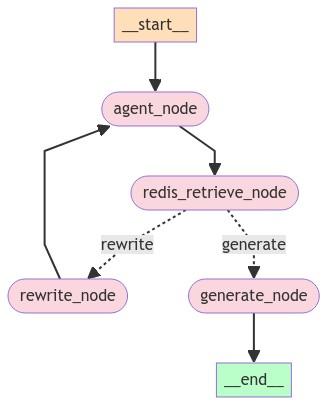

In [36]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("agent_node", agent)  # agent
workflow.add_node("redis_retrieve_node", execute_tools)
workflow.add_edge("agent_node", 'redis_retrieve_node')
workflow.add_node("rewrite_node", rewrite)
workflow.add_edge("rewrite_node", "agent_node")
# Decide whether to retrieve
workflow.add_conditional_edges(
    "redis_retrieve_node",
    check_relevancy,
    {
        # Translate the condition outputs to nodes in our graph
        "rewrite": "rewrite_node",
        "generate": "generate_node",
    },
)

workflow.add_node("generate_node", generate)
workflow.add_edge("generate_node", END)

workflow.set_entry_point("agent_node")

# Compile
graphapp = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graphapp.get_graph(xray=True).draw_mermaid_png()))
except:
    pass


In [37]:
import pprint

inputs = {
    "input":"What was the deferred revenue of aapl in 2022?",
}
for output in graphapp.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent_node':"
'---'
{ 'agent_outcome': AgentAction(tool='get_relevant_docs_from_redis', tool_input='aapl" and "2022', log='I\'m ready to assist with financial document-related questions!\n\nSince this is a specific question about Apple\'s (AAPL) financials, I\'ll use my tools to try and find relevant documents.\n\nAction: get_relevant_docs_from_redis\nAction Input: "aapl" and "2022')}
'\n---\n'
RFD-DEBUG: ======== Called `execute_tools`========
Calling tool: get_relevant_docs_from_redis
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
"Output from node 'redis_retrieve_node':"
'---'
{ 'documents': [ 'The Company’s proportion of net sales by disaggregated '
                 'revenue source was generally consistent for each reportable '
                 'segment in Note 11, “Segment Information and Geographic '
                 'Data” for 2022, 2021 and 2020, except in Greater China, '
  

In [38]:
import pprint

inputs2 = {
    "input":"Why colorless green ideas are furiously sleeping?",
    "messages": [
        ("user", "Why colorless green ideas are furiously sleeping?"),
    ]
}

for output2 in graphapp.stream(inputs2):
    for key2, value2 in output2.items():
        pprint.pprint(f"Output from node '{key2}':")
        pprint.pprint("---")
        pprint.pprint(value2, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent_node':"
'---'
{ 'agent_outcome': AgentAction(tool='response_to_irrelevant_questions', tool_input='None', log="I'm an assistant for financial document-related tasks, but I sense that this question is not relevant to finance.\n\nAction: response_to_irrelevant_questions\nAction Input: None")}
'\n---\n'
RFD-DEBUG: ======== Called `execute_tools`========
Calling tool: response_to_irrelevant_questions
"Output from node 'redis_retrieve_node':"
'---'
{ 'documents': [],
  'intermediate_steps': [ ( AgentAction(tool='response_to_irrelevant_questions', tool_input='None', log="I'm an assistant for financial document-related tasks, but I sense that this question is not relevant to finance.\n\nAction: response_to_irrelevant_questions\nAction Input: None"),
                            'Your question does not seem to be relevant to '
                            'finance. Please only ask questions that are '
                            'relevant to financials of companies that a